A lot of the code for setting up the model is either taken from or inspired by this blog post: https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

### Data loading and prep

In [ ]:
ratings = pd.read_pickle("./Data/reviews_20_1000_longform.pkl")

In [6]:
ratings.shape

(8854093, 3)

In [7]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(64815, 89418)

In [45]:
ratings.shape

(8854093, 5)

In [8]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape

((6197865, 3), (2656228, 3))

### Train the model

In [7]:
def train_test_model(output_bias):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    bias = keras.initializers.Constant(output_bias)
    
    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    
    dense1 = keras.layers.Dense(128,activation='relu', kernel_regularizer='l2')(conc_layer)
    
    dropout1 = keras.layers.Dropout(rate=.6, seed=42)(dense1)
    
    dense2 = keras.layers.Dense(64,activation='relu', kernel_regularizer='l2')(dropout1)
    
    dropout2 = keras.layers.Dropout(rate=.5, seed=42)(dense2)
    
    dense3 = keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(dropout2)
    
    dropout3 = keras.layers.Dropout(rate=.4, seed=42)(dense3)
    
    dense4 = keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(dropout3)
    
    x_out = keras.layers.Dense(1, activation='relu', kernel_regularizer='l2', bias_initializer=bias)(dense3)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=.01)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())

    return model

In [12]:
model = train_test_model(output_bias=7)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        24735       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        35865       input_2[0][0]                    
______________________________________________________________________________________________

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                        min_delta=.001,
                                        patience=30,
                                        mode="auto",
                                        restore_best_weights=True)

output = model.fit([X_train.movie, X_train.user], 
                    X_train.rating_score,  
                    batch_size=len(X_train), 
                    epochs=100, 
                    validation_split=.2,
                    callbacks=[callback])

Epoch 1/100
1/1 [==============================] - 15s 15s/step - loss: 13.6929 - root_mean_squared_error: 3.4515 - val_loss: 12.5734 - val_root_mean_squared_error: 3.3108
Epoch 2/100
1/1 [==============================] - 10s 10s/step - loss: 12.5283 - root_mean_squared_error: 3.3040 - val_loss: 10.8730 - val_root_mean_squared_error: 3.0645
Epoch 3/100
1/1 [==============================] - 8s 8s/step - loss: 10.7937 - root_mean_squared_error: 3.0516 - val_loss: 8.1644 - val_root_mean_squared_error: 2.6034
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 8.1149 - root_mean_squared_error: 2.5939 - val_loss: 4.6072 - val_root_mean_squared_error: 1.8123
Epoch 5/100
1/1 [==============================] - 9s 9s/step - loss: 4.7049 - root_mean_squared_error: 1.8390 - val_loss: 2.5206 - val_root_mean_squared_error: 1.1123
Epoch 6/100
1/1 [==============================] - 8s 8s/step - loss: 3.1600 - root_mean_squared_error: 1.3699 - val_loss: 4.7601 - val_root_mean_squar

In [14]:
callback.best

0.8396117091178894

### Evaluate model results

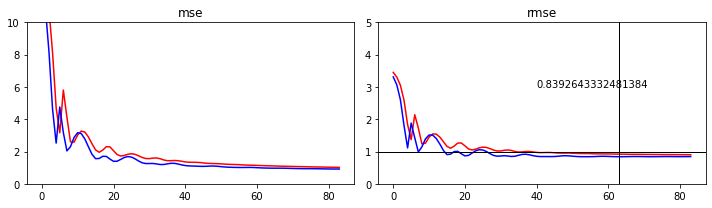

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))


axs[0].plot(output.history['loss'], color='r')
axs[0].plot(output.history['val_loss'], color='b')

axs[1].plot(output.history['root_mean_squared_error'], color='r')
axs[1].plot(output.history['val_root_mean_squared_error'], color='b')
axs[1].axvline(np.where(output.history['val_root_mean_squared_error']==np.min(output.history['val_root_mean_squared_error'])), 
                 color='k', lw=1)
axs[1].annotate(str(np.min(output.history['val_root_mean_squared_error'])),
                    xy=(40,3),)

axs[0].set_title("mse")
axs[1].set_title("rmse")

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,5)

axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [19]:
def is_close_enough(pred, ratings):
    '''function to determine whether estimated ratings are close enough to actual ratings'''
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [18]:
X_train.groupby('user').count().sort_values(by='movie',ascending=False).head()

,movie,rating_score
user,,
49758,735,735
46967,734,734
14547,722,722
40854,719,719
20490,718,718


evaluate model for a single user

In [16]:
user = 58315
ratings[ratings.user==user]

,movie_id,rating_score,user_id,user,movie
13381,1085,4,89904558,58315,1038
19800,1094,4,89904558,58315,1047
23850,1099,2,89904558,58315,1052
35843,1103,5,89904558,58315,1056
48584,1116,3,89904558,58315,1069
...,...,...,...,...,...
15428890,981,2,89904558,58315,941
15489675,1046,3,89904558,58315,1002
15493413,1047,2,89904558,58315,1003
15498925,1049,2,89904558,58315,1005


In [17]:
movie_array = ratings[ratings.user==user].movie.values.astype(int)
user_array = np.array([int(user) for n in range(len(movie_array))])

In [18]:
pred = model.predict([movie_array, user_array])

In [20]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)

In [21]:
sum(val) / len(pred.flatten())

0.5220440881763527

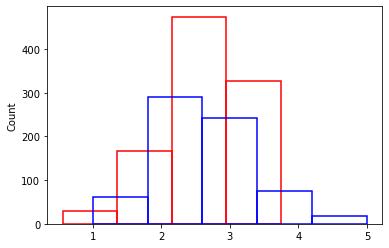

In [22]:
sns.histplot(pred.flatten(), bins=4, color='red', fill=False)
sns.histplot(X_train[X_train.user==user].rating_score.values, bins=5, color='blue', fill=False)

plt.show()

Evaluate model for the 20 users with the most ratings in this subset.

In [23]:
top_20_users = X_train.groupby('user').count().sort_values(by='movie',ascending=False).head(20).index

In [24]:
predictions = []

for user in top_20_users:
    movie_array = X_train[X_train.user==user].movie.values.astype(int)
    user_array = np.array([int(user) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)
    
    predictions.append(list(pred.flatten()))
    print(user, sum(val) / len(pred.flatten()))

49758 0.40816326530612246
46967 0.3896457765667575
14547 0.3808864265927978
40854 0.4297635605006954
20490 0.3022284122562674
13686 0.40585774058577406
18058 0.3263598326359833
28524 0.4167832167832168
38238 0.3848314606741573
13828 0.3693820224719101
41054 0.41068917018284107
1380 0.37799717912552894
55147 0.3135593220338983
10210 0.39745403111739747
5321 0.371994342291372
14125 0.4490084985835694
6497 0.34844192634560905
17796 0.4164305949008499
59336 0.4156028368794326
2488 0.5752840909090909


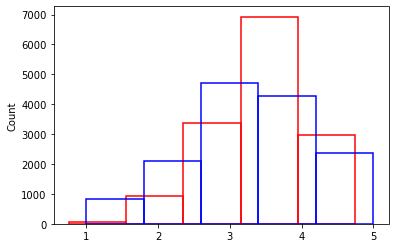

In [27]:
sns.histplot(list(flatten(predictions)), bins=5, color='red', fill=False)
sns.histplot(X_train[X_train.user.isin(top_20_users)].rating_score.values, bins=5, color='blue', fill=False)

plt.show()

Do the same, but for 20 random users. 

In [33]:
random_20_users = random.choices(X_train.user.unique(), k=20)

In [34]:
predictions = []

for user in random_20_users:
    movie_array = X_train[X_train.user==user].movie.values.astype(int)
    user_array = np.array([int(user) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)
    
    predictions.append(list(pred.flatten()))
    print(user, sum(val) / len(pred.flatten()))

51322 0.4198473282442748
10720 0.6046511627906976
63366 0.38461538461538464
28880 0.5384615384615384
16810 0.5714285714285714
61459 0.5263157894736842
63212 0.6944444444444444
22558 0.6513761467889908
61437 0.7087378640776699
3751 0.39285714285714285
6251 0.8823529411764706
2802 0.7428571428571429
30134 0.4827586206896552
16424 0.31718061674008813
50910 0.3471882640586797
52062 0.7058823529411765
55578 0.8
57625 0.8
36341 0.6153846153846154
19773 0.32


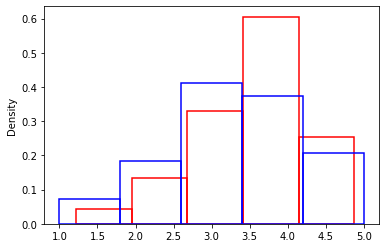

In [41]:
sns.histplot(list(flatten(predictions)), bins=5, color='red', fill=False,
            stat='density', common_norm=False)


sns.histplot(X_train[X_train.user.isin(top_20_users)].rating_score.values, bins=5, color='blue', fill=False,
            stat='density', common_norm=False)

plt.show()

### Save everything

In [42]:
!mkdir -p saved_model
model.save('saved_model/rmse_839')

INFO:tensorflow:Assets written to: saved_model/rmse_839/assets


In [43]:
model.save('saved_model/rmse_839/model.h5')

In [44]:
pd.to_pickle(X_train, 'saved_model/rmse_839/X_train.pkl')
pd.to_pickle(X_test, 'saved_model/rmse_839/X_test.pkl')